# accessibility analysis 
in this notebook you will perform a street-segment and building level accessibility analysis using a network using a library for accessibility analyses and data aggregation across networks called pandana.


the entire analysis will be performed using open sourced data from OpenStreetMap (OSM)
you can add additional data sources if you have them


1. you will download a network from osmnx - you've done this before
2. you will download points of interest (pois) of a type you choose from OSM
3. you will perform a nearest point query on the network - looking for the nearest poi to each node
4. you will perform network aggregation analyses using different radii and decay functions
5. you will think of a way to rank street segments
5. you will download building footprint data from OSM and link the results of you analysis to buildings in the city


In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import pandana as pdna
import osmnx as ox
import matplotlib, matplotlib.pyplot as plt, seaborn as sns
from shapely.geometry import *
%matplotlib inline

### get real data from Open Street Map
https://osmnx.readthedocs.io/en/stable/ <br/>
https://github.com/gboeing/osmnx

you've used osm driving network in the past, this time you'll use the walking network.

use   `ox.graph_from_place([your place of analysis], network_type='walk')`

use `ox.plot_graph(G)` to plot the network

In [2]:
G =ox.graph_from_place("Jerusalem, Israel", network_type='walk')

get the basic stats using `ox.basic_stats(G)`

### lets create geopandas geodataframes for the nodes and edges in the network:
use `nodes, edges = ox.save_load.graph_to_gdfs(G)`

and also save to shapefile using `ox.save_graph_shapefile(G, filename='jer_network')`
    

In [3]:
nodes, edges = ox.save_load.graph_to_gdfs(G)

### Coordinate system

explore the nodes and edges data frames.
use `df.crs` to find out the coordinate system of the dataframe.

to to the following spatial reference list web site to lookup this epsg code and to find 
a coordinate system to convert the dataframes into (use `df= df.to_crs({'init': 'epsg:[new code]'})`)


https://spatialreference.org/ref/epsg/

In [6]:
nodes.crs

{'init': 'epsg:4326'}

In [4]:
nodes = nodes.to_crs({'init': 'epsg:2039'})
edges = edges.to_crs({'init': 'epsg:2039'})

now we have a network in a local coordinate system

We can use geopandas `plot` mothod to plt both our nodes and edges

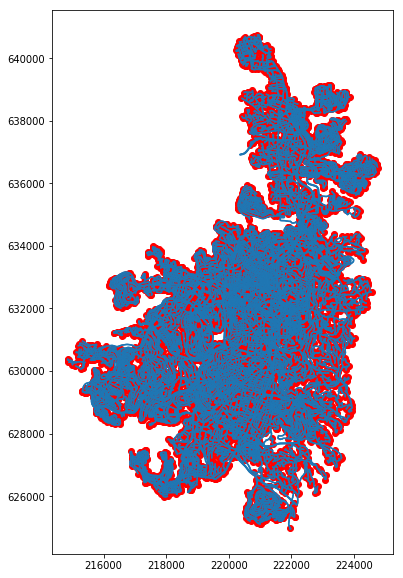

In [5]:
fig, ax = plt.subplots(figsize = (10,10))
nodes.plot(ax = ax, color = 'red')
edges.plot(ax = ax)

### acquiring points of interest from osm


osmnx as a poi module
https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.pois

use `osmnx.pois.create_poi_gdf()` to fetch point of interest from osm.

before you start - go to the api and see what you need in order to get the pois 
you want

for the type of amenities to use go to the osm wiki page on amenities https://wiki.openstreetmap.org/wiki/Key:amenity


hint: you can use the data you already have or use `osmnx.core.gdf_from_place` to get the desired location

In [6]:
pois = gpd.GeoDataFrame.from_file('../data/stops_jer.geojson')

In [7]:
pois.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id,in_degree,pr,out_degree,dc,cc,bc,hb,au,geometry
0,7320,60028,הרב פרדס/צוקרמן,רחוב:מעגלות הרב פרדס 11 עיר: ירושלים רציף: ...,31.843870,35.243665,0,NaN,3000,523,0.000422,523,0.516034,0.049975,0.007558,9.779409e-156,1.130308e-242,POINT (35.243665 31.84387)
1,7661,60413,קבר רחל,רחוב:דרך חברון עיר: ירושלים רציף: קומה:,31.720193,35.202604,0,NaN,3000,0,0.000083,27,0.013320,0.000000,0.000000,1.487756e-198,0.000000e+00,POINT (35.202604 31.720193)
2,7662,60414,קבר רחל,רחוב:דרך חברון עיר: ירושלים רציף: קומה:,31.720059,35.202433,0,NaN,3000,28,0.000485,0,0.013814,0.058037,0.000000,0.000000e+00,7.895681e-188,POINT (35.202433 31.720059)
3,8404,61157,הרב פרדס/מאיר בלבן,רחוב:מעגלות הרב פרדס עיר: ירושלים רציף: קו...,31.844983,35.242000,0,NaN,3000,499,0.000179,499,0.492353,0.047359,0.000449,8.664058e-156,1.868272e-155,POINT (35.242 31.844983)
4,8405,61158,הרב פרדס/מאיר בלבן,רחוב:מעגלות הרב פרדס עיר: ירושלים רציף: קו...,31.844819,35.241602,0,NaN,3000,570,0.000700,570,0.562407,0.056367,0.007202,2.434381e-207,3.483591e-154,POINT (35.241602 31.844819)


now that we have our pois dataframe - let convert its coordinate system

In [8]:
pois.crs

{'init': 'epsg:4326'}

In [9]:
pois = pois.to_crs({'init': 'epsg:2039'})

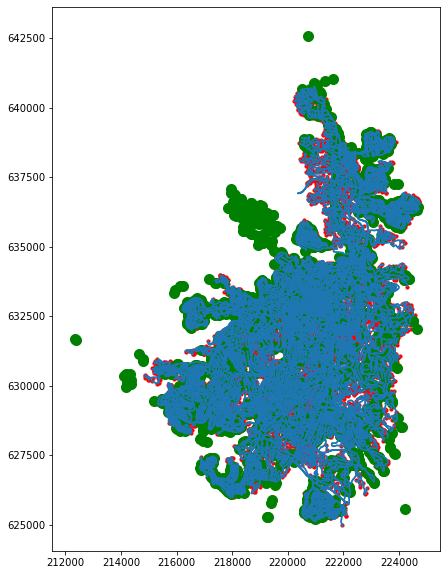

In [13]:
fig, ax = plt.subplots(figsize = (10,10))
nodes.plot(ax = ax, color = 'red', markersize = 10)
edges.plot(ax = ax)
pois.plot(ax = ax, markersize = 100, color = 'green')

### lets initialize a pandana network

`net=pdna.Network(nodes.x, 
                 nodes.y, 
                 edges["from"], 
                 edges["to"],
                 edges[["weight"]])`

will initialize the network


```net.precompute(3000)```

will precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily. here, 3000 meters is used as the horizon distance (optional)


#### note:
in the network you downloaded some of the column names maybe different and some of the 
columns should be re-computed

In [14]:
nodes['x'] = nodes['geometry'].x
nodes['y'] = nodes['geometry'].y
edges['length'] = edges['geometry'].length

In [17]:
edges.head()

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,tunnel,u,v,width
0,NaN,NaN,LINESTRING (220887.6043664573 627739.291187045...,track,NaN,0,NaN,165.861897,NaN,NaN,False,183039135,NaN,NaN,NaN,1932197894,1933999331,NaN
1,NaN,yes,LINESTRING (220887.6043664573 627739.291187045...,tertiary,NaN,0,NaN,110.955171,NaN,לייב יפה,False,"[183052712, 27295634, 79657278]",NaN,NaN,NaN,1932197894,2379440750,NaN
2,NaN,NaN,LINESTRING (220887.6043664573 627739.291187045...,tertiary,NaN,0,NaN,20.072936,NaN,לייב יפה,False,183052712,NaN,NaN,NaN,1932197894,1932197872,NaN
3,NaN,NaN,LINESTRING (220887.6043664573 627739.291187045...,footway,NaN,0,NaN,267.209570,NaN,NaN,False,374470338,NaN,NaN,NaN,1932197894,3778586902,NaN
4,NaN,NaN,LINESTRING (220887.6043664573 627739.291187045...,footway,NaN,0,NaN,27.020692,NaN,NaN,False,374472448,NaN,NaN,NaN,1932197894,3778603099,NaN


In [18]:
net=pdna.Network(nodes.x, 
                 nodes.y, 
                 edges["u"], 
                 edges["v"],
                 edges[["length"]])

/Users/ml/anaconda3/envs/geoenv4/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/Users/ml/anaconda3/envs/geoenv4/lib/python3.6/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/Users/ml/anaconda3/envs/geoenv4/lib/python3.6/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/Users/ml/anaconda3/envs/geoenv4/lib/python3.6/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### lets add our pois to the network
you want to  create a x and y series from the pois df


first run `pois['geometry'] = [x.centroid if isinstance(x, (Polygon, MultiPolygon)) else x for x in pois['geometry']]`
in order to convert any non point geometry in the poi df to point

then use `pois['geometry'].x` and `pois['geometry'].y`

In [19]:
x,y = pois['geometry'].x , pois['geometry'].y
net.set_pois("stops", 800, 2000, x, y)

/Users/ml/anaconda3/envs/geoenv4/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


use `net.set_pois("type of poi", distance, number_of_pois, x, y)` to add the pois to the network

### Nearest pois queries
use
`net.nearest_pois(distance, "type of poi", num_pois)`
to create a df with the num_pois number of closest pois

This searches for the num_pois nearest pois, This returns a DataFrame with the number of columns equal to the number of POIs that are requested.

#### note:
pois with distance equal to that of the maximum - might be farther away - this only means
that the analysis stops at that radius

In [22]:

net.nearest_pois(800, "stops", 10, include_poi_ids=True).head()

,1,2,3,4,5,6,7,8,9,10,poi1,poi2,poi3,poi4,poi5,poi6,poi7,poi8,poi9,poi10
1932197894,258.760010,258.760010,367.787994,428.933014,564.338989,564.338989,685.851990,685.851990,691.965027,727.830994,1022.0,1023.0,512.0,533.0,954.0,534.0,1678.0,273.0,955.0,1253.0
1932197896,414.820007,414.820007,523.848022,537.689026,537.689026,582.617981,584.992981,651.526001,720.398987,720.398987,1022.0,1023.0,512.0,273.0,1678.0,1246.0,533.0,1254.0,954.0,534.0
2849308695,135.608002,135.608002,179.830002,179.830002,211.740005,239.684998,239.684998,306.093994,316.707001,316.707001,181.0,169.0,182.0,93.0,94.0,179.0,95.0,180.0,96.0,1121.0
2696806426,19.197001,86.167000,120.161003,149.865005,182.022003,324.820007,346.347992,395.841003,398.520996,403.070007,1305.0,1433.0,1389.0,307.0,33.0,35.0,1656.0,1407.0,1217.0,1408.0
3791847456,259.023010,446.299988,462.774994,475.502014,622.794006,622.794006,626.093018,631.866028,661.219971,686.585999,232.0,407.0,592.0,234.0,235.0,258.0,233.0,408.0,223.0,231.0


### network aggregation

in order to perform network aggregation queries we need to relate the pois x and y series to nodes in the network

#### get and set x,y:
use `node_ids = net.get_node_ids(x, y)` to get the node ids associated with the pois 

use `net.set(node_ids, "type of poi")` to assign the location to the network

In [47]:
node_ids = net.get_node_ids(x, y)
net.set(node_ids, variable = pois['dc'], name = "stops")

/Users/ml/anaconda3/envs/geoenv4/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


new you can query the network:
    the aggregation can be performed im different radiuses
    the type of analysis can be sum or count - try both
    three decay function are available: linear , flat and exponential - try each one
for example:


```a = net.aggregate(800, type="sum", decay="linear", name = "atm and bank")
b = net.aggregate(800, type="count", decay="flat", name = "atm and bank")```


this will return panda series with results - look at them
        

In [48]:
a = net.aggregate(800, type="sum", decay="linear", name = "stops")

In [49]:
i = ('a', a)
edges['u_score_'+i[0]] = i[1].loc[edges['u'].tolist()].values
edges['v_score_'+i[0]] = i[1].loc[edges['v'].tolist()].values
edges['mean_score_'+i[0]] = edges[['u_score_'+i[0],
                                              'v_score_'+i[0]]].mean(axis = 1)

In [28]:
b = net.aggregate(800, type="count", decay="linear", name = "stops")
i = ('b', b)
edges['u_score_'+i[0]] = i[1].loc[edges['u'].tolist()].values
edges['v_score_'+i[0]] = i[1].loc[edges['v'].tolist()].values
edges['mean_score_'+i[0]] = edges[['u_score_'+i[0],
                                              'v_score_'+i[0]]].mean(axis = 1)

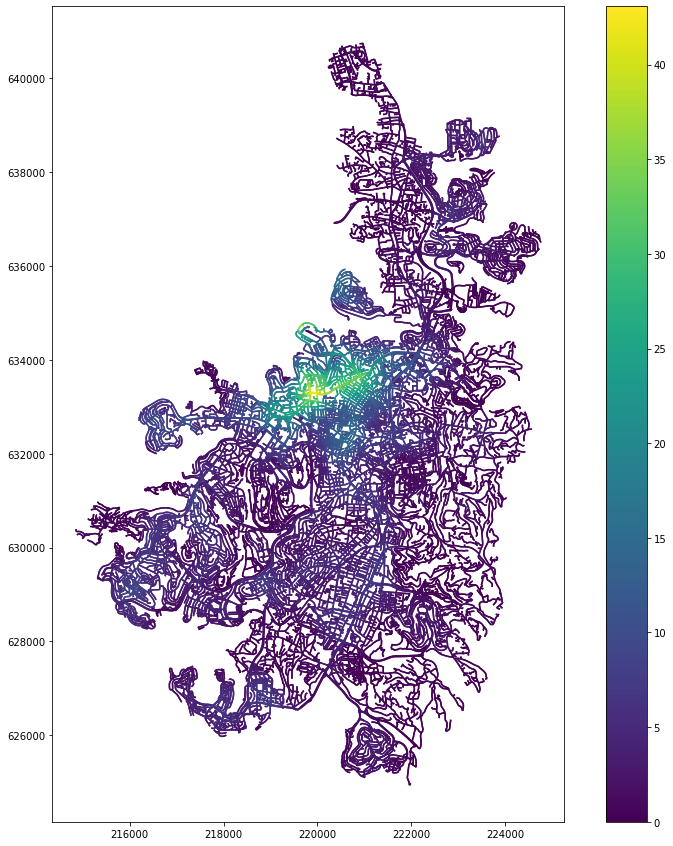

In [50]:
edges.plot(column = 'mean_score_a', figsize = (15,15), legend = True)

In [52]:
edges[['geometry', 'mean_score_a']].to_file('../data/jer_edges_dc.geojson', driver = 'GeoJSON')

### assign score to edges

now that you have a score for each node - think of a way 
to assign the score to edges

### donload a building footprin layer from OSM and assign scores to buildings

use `ox.footprints.create_footprints_gdf(polygon,  footprint_type='building')`

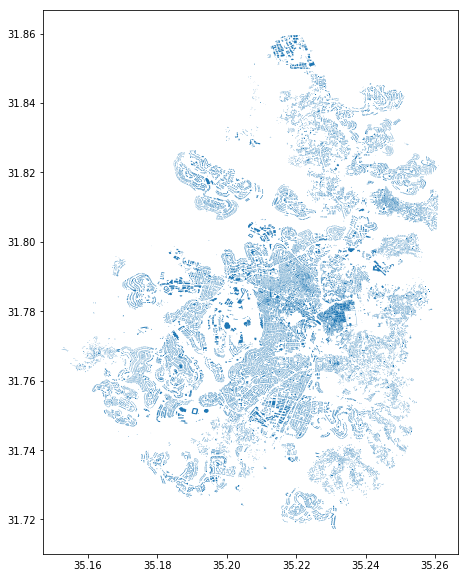

In [37]:
blds.plot(figsize = (10,10))

extract the buildings centroid:
make a copy of the building footprint dataframe and change the geometry to centrois like so:


```blds_cent = blds.copy()
blds_cent['geometry'] = blds_cent['geometry'].centroid```


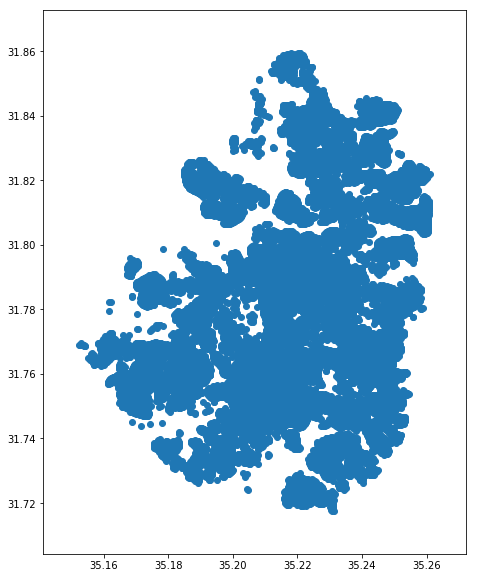

In [176]:
blds_cent.plot(figsize = (10,10))

find a way to assign the closest node_id to each building's centroid 

hint: you've done this before

In [39]:
blds_cent.crs

{'init': 'epsg:4326'}

/home/me/anaconda3/envs/geoenv7/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


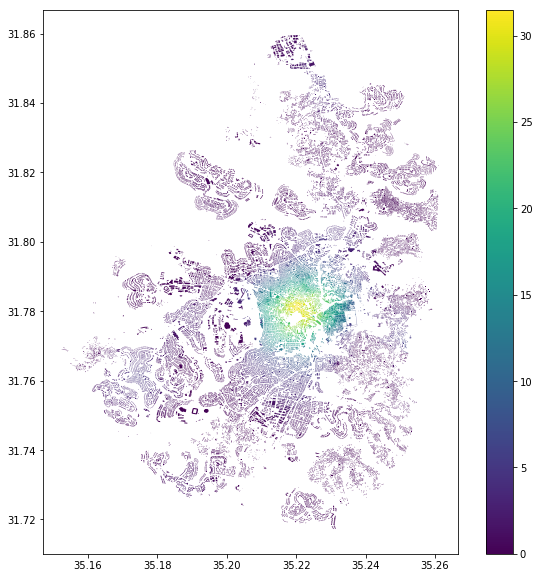

In [42]:
blds.plot(column = 'score', legend = True, figsize = (10,10))

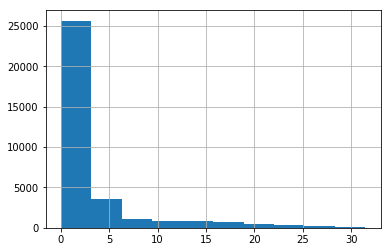

In [43]:
blds['score'].hist()